In [1]:
#my python module
!pip install collinearity jenkspy   
from pathlib import Path
import pandas as pd
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sys
import subprocess

try:
    import google.colab

    ENV_IS_CL = True
    cwd = r"/content/ml_WSM"
    sys.path.insert(0, cwd)
    subprocess.run(["git", "clone",  "https://github.com/whitelightning450/Machine-Learning-Water-Systems-Model", "ml_WSM"])
except:
    cwd = os.getcwd()
    
cwd = Path(cwd)

import XGB_Model

In [2]:

#This is the final dataset to make predictions on
p = cwd.joinpath('Training_Simulations')

Sims = {i.stem[0:8] : pd.read_excel(i, skiprows = 5) for i in p.glob('**/*.xlsx')}



Processing data to tune XGBoost model for  Mtn_Dell_Percent_Full
This may take a few moments depending on computational power and data size
Calculating collinearity matrix and removing features >  0.9
Feature development time 0 s


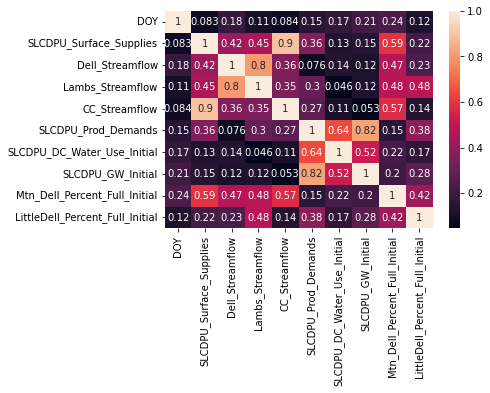

In [184]:
'''
A list of all of the model input features and the target.
Data takes in Goldsim simulations and splits them into training/testing.
Each simulation is the same for the training period (2000-2020)
Testing data varies based on climate scenario (Ave_Clim, Dro_Clim, Sur_Clim)

The data processing also adds a few features (the previous time steps target values and time variables)
'''
feat = [
    #Time
    'DOY' , 'Month',
    #Streamflow , 
     'SLCDPU_Surface_Supplies','BCC_Streamflow',  'LCC_Streamflow','Dell_Streamflow',
    'Lambs_Streamflow', 'CC_Streamflow',
    #Demands 
    'SLCDPU_Prod_Demands','SLCDPU_DC_Water_Use_Initial','SLCDPU_GW_Initial', 
    #Reservoir Levels
   'Mtn_Dell_Percent_Full_Initial','LittleDell_Percent_Full_Initial']

'''
select your target you want to train a model for:
(SLCDPU_GW, Mtn_Dell_Percent_Full, LittleDell_Percent_Full, SLCDPU_DC_Water_Use)

'''

targ = ['Mtn_Dell_Percent_Full'] 


#load Data processing module
DataProcc = XGB_Model.XGB_Tuning(cwd)

#Load in data and process accordingly
DataProcc.ProcessData(Sims, 'Obs_Ave', feat, targ, 2021, False, allData = True, cwd=cwd)

'''
This step check to collinearity among features.
In the instance feature collinearity exceeds the threshold (col_threashold),
the lesser correlated feature to the target will be removed.
These remaining features go to the next step, Recursive Feature Elimination

'''

DataProcc.CollinearityRemoval(col_threshold= .9)


In [185]:
'''
This step uses recursive feature elimination to identify the optimial features for the XGBoost
algorithm and the specific water system target. The function searches from 2 features to the maximum 
collinearity check features to determint the optimial targets features.
'''
#Run RFE feature selection to identify good features
DataProcc.FeatureSelection()

#from thorough analysis and testing, use these identified features
DataProcc.Feature_Optimization()

Using RFE to determine optimial features, scoring is:
>2 -0.474 (0.017)
>3 -0.365 (0.013)
>4 -0.310 (0.013)
>5 -0.300 (0.011)
>6 -0.293 (0.013)
>7 -0.285 (0.013)
>8 -0.286 (0.019)
>9 -0.284 (0.015)
   index  n_feat  mean_MAE   std_MAE
0      3     5.0  0.299547  0.011499
1      5     7.0  0.285455  0.012755
2      4     6.0  0.292753  0.012802
3      2     4.0  0.309976  0.012882
4      1     3.0  0.365124  0.013207
5      7     9.0  0.284057  0.015063
6      0     2.0  0.474393  0.017166
7      6     8.0  0.285996  0.018733
[False False  True False  True  True False  True  True False]
[3 5 1 2 1 1 6 1 1 4]
The Recursive Feature Elimination identified features are: 
['Dell_Streamflow', 'CC_Streamflow', 'SLCDPU_Prod_Demands', 'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial']
Feature selection time:  55 s
 
Features optimization identifies the following features best fit for the XGB-WSM
The final features for  Mtn_Dell_Percent_Full are: 
Index(['SLCDPU_Surface_Supplies', 'Dell_Stream

In [12]:

#Identify optimal water system component Parameters
#Any range can be used, however the following are optimized.

if targ[0] =='Mtn_Dell_Percent_Full':  #Excellent good.
    parameters = {
                  'nthread':[-1], #my identified features, prev
                  'objective':['reg:squarederror'],
                  'learning_rate': [.9], #0.1, 0.3, 1, 0.01
                  'max_depth': [3], #4,5, 3, 5
                  'min_child_weight': [5], #6,4, 1 (5),5
                  'subsample': [0.9], #0.7,0.9, 0.9
                  'colsample_bytree': [0.8], #0.8, 0.8
                  "reg_lambda":[1.5], #1,1, 1.5,4.5
                  'reg_alpha': [1.5],  #0,0, 1.5, 1.7
                  'n_estimators': [800], #375,350, 750, 400
                   'n_jobs':[-1]
                                       }
    

if targ[0] =='LittleDell_Percent_Full':  #Very good!, note, below params are for feature subsets
    parameters = {
                  'nthread':[-1], #when use hyperthread, xgboost may become slower
                  'objective':['reg:squarederror'],
                  'learning_rate': [ .4], #0.5 , 0.01, 0.4
                  'max_depth': [3], #3, 5 , 3
                  'min_child_weight': [4], #4 , 4, 4
                  'subsample': [0.8], #0.8, 0.5 , 0.8
                  'colsample_bytree': [0.8], #0.8, 0.8, 0.8
                  "reg_lambda":[0], #0,1 ,0
                  'reg_alpha': [0], #0,0, 0
                  'n_estimators': [20000], #1900, 500, 20000
                   'n_jobs':[-1]
                                       }
if targ[0] =='SLCDPU_DC_Water_Use':  #Good!
    parameters = {
                  'nthread':[-1], #when use hyperthread, xgboost may become slower
          'objective':['reg:squarederror'],
          'learning_rate': [.3], # 0.3 is good too
          'max_depth': [3], #3
          'min_child_weight': [8], #8
          'subsample': [0.8], #,0.8 is good
          'colsample_bytree': [0.8], #0.8 is good.
          "reg_lambda":[0], #0
          'reg_alpha': [0], #0
          'n_estimators': [20000],#10000, 20000 is good too
           'n_jobs':[-1]
                                       }

if targ[0] =='SLCDPU_GW':
    parameters = {
                  'nthread':[-1], #when use hyperthread, xgboost may become slower
                  'objective':['reg:squarederror'],
                  'learning_rate': [0.3], #0.3
                  'max_depth': [3], #3
                  'min_child_weight': [6], #6
                  'subsample': [0.6], #0.6
                  'colsample_bytree': [0.6], #0.6
                  "reg_lambda":[0], #0
                  'reg_alpha': [0], #0
                  'n_estimators': [500], #500
                   'n_jobs':[-1]
                                       }




#using the respective parameters, identifiy the optimal hyper-parameters the respective XGBoost model
DataProcc.GridSearch(parameters) 


Performing a Grid Search to identify the optimial model hyper-parameters
Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best hyperparameter three-fold cross validation score is: 
0.994827082860787
 
The optimal hyper-parameters are: 
{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 750, 'n_jobs': -1, 'nthread': -1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}
 
Hyper-parameter Optimization time 3 s


Performing a Grid Search to identify the optimial model hyper-parameters
Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best hyperparameter three-fold cross validation score is: 
0.9969629745888297
 
The optimal hyper-parameters are: 
{'colsample_bytree': 0.8, 'learning_rate': 0.9, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 800, 'n_jobs': -1, 'nthread': -1, 'objective': 'reg:squarederror', 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.9}
 
Hyper-parameter Optimization time 2 s
Model Training
Calibration time 1 s
Saving Model
prediction time 0 s


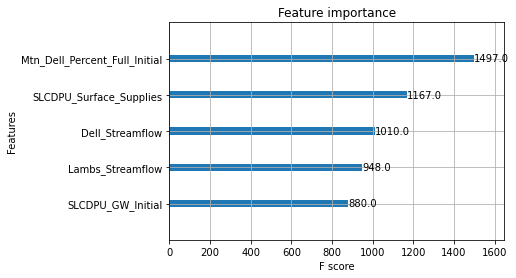

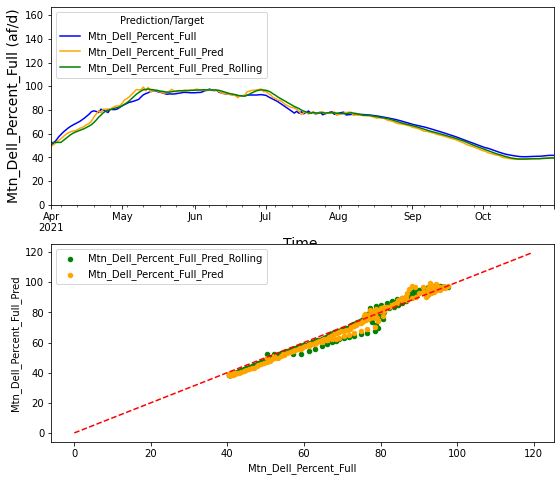

RMSE for predictions:  2.935597979141027 . RMSE for rolling prediction mean:  3.059649029127292


In [200]:

#set directory to save model
M_save_filepath = "/Model_History/V2/XGBoost_"+targ[0]+".dat"

#need to separate the train vs predict
DataProcc.Train(M_save_filepath) 

'''
Test the model and make a prediction on the unseen target for the respective water year
'''

#Make a prediction to evaluate each model
#XGBoost
XGBboost = XGB_Model.XGB_model(targ[0], cwd)
XGBboost.XGB_Predict(DataProcc.test_feat[DataProcc.Final_Features], DataProcc.test_targs)   
#Plot the prediction results
XGBboost.PredictionPerformancePlot()

